## **Usando machine learning na Previsão de Falhas de maquinários**

In [3]:
!pipreqsnb "C:\Users\marco\Downloads\desafio"


pipreqs  C:\Users\marco\Downloads\desafio


INFO: Successfully saved requirements file in C:\Users\marco\Downloads\desafio\requirements.txt


O objetivo deste notebook, é avaliar os potenciais falhas de uma determinada maquina de uma fabrica. Para isto foram feitas todo o processo de importação dos dados, tratamento e modificação necessaria do dataset, além de todo o processo de engenharia de feature e treinamento do modelo.  

### Importando e tratando dados 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import  classification_report,accuracy_score, confusion_matrix, auc

  


In [4]:
#carregando dados 
df = pd.read_csv('/content/desafio_manutencao_preditiva_treino.csv')
df_teste = pd.read_csv('/content/desafio_manutencao_preditiva_teste.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/desafio_manutencao_preditiva_treino.csv'

In [ ]:
#verificando os 5 primeiro dados 
df_teste.head()

In [ ]:
#tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


Dicionario dos dados 


---

* **UID**: unique identifier ranging from 1 to 10000
* **Product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
* **Type**: just the product type L, M or H from column 2
* **Air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
* **Process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
* **Rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise
* **Torque [Nm]**: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
* **Tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.





In [ ]:
#valores nulos
df.isnull().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

In [ ]:
#linhas e colunas 
df.shape

(6667, 9)

O dataset possui 6667 linhas e 9 colunas

In [3]:
features_numericas = df.select_dtypes(include='number').columns.tolist()
#separando o dataset features numericas.
features_categoricas = df.select_dtypes(include = 'object').columns.tolist()
#separando o dataset features categoricas.

In [ ]:
print('Features numericas: {}'.format(features_numericas))

Features numericas: ['udi', 'air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']


As features numéricas são:

* Type, 
* Air_temperature_k, 
* Process_temperature_k, 
* Rotational_speed_rpm, 
* Torque_nm, tool_wear_min, 
* Failure_type

In [ ]:
print('Features categoricas: {}'.format(features_categoricas))

Features categoricas: ['product_id', 'type', 'failure_type']


Ja as features categoricas são:

* Product_id 
* Type 
* Failure_type

In [ ]:
#verificando os valores unicos 
df['failure_type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

Derivei a variavel failure_type para verificar quantas colunas apresentaram falhas na maquina, e quantas não apresentaram .

In [ ]:
#criando um for para verificar quais maquinas apresentaram falhas, quais não apresentaram
# se a maquina apresentar falha = 1
# se não apresentar = 0.
df['failure'] = [0 if x=='No Failure' else 1 for x in df['failure_type']]


Deletei as variaveis udi e product_id para nao afetar a analise exploratória 

In [64]:
df = df.drop(["udi",'product_id'], axis = 1)

#deletando o udi = id


In [65]:
df_teste =  df_teste.drop(["udi",'product_id'], axis = 1)

### Analise exploratoria

In [ ]:
df.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,4994.589921,299.992515,309.992620,1537.419529,40.058512,108.098095
std,2896.125718,1.994710,1.488101,177.182908,9.950804,63.359915
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,2496.500000,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,4983.000000,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,7510.500000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,251.000000


  **Air_temperature_k**
* Media : 299.99
* Desvio Padrão: 1.99
* Temperatura do ar minima: 295.30
* Temperatura do ar maxima: 304.50
---




  **Process_temperature_k**
* Media : 309.99
* Desvio Padrão: 1.48
* Temperatura do ar minima: 305.7
* Temperatura do ar maxima: 313.8

---

  **Rotational_speed_rpm**
* Media : 1537.41
* Desvio Padrão: 177.18
* Velocidade rotacional minima: 1168 rpm
* Velocidade Rotacional maxima: 2886 rpm

---

  **Torque_nm**
* Media : 40.05
* Desvio Padrão: 9.95
* Valor minimo: 3.8 rpm
* Valor maximo: 76 rpm

---

  **tool_wear_min**
* Media : 108.09
* Desvio Padrão: 63.35
* Valor minimo: 0
* Valor  maximo: 151 rpm

---

Após isso verifiquei a distribuição das principais variaveis numericas 


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


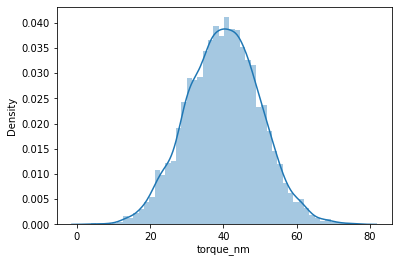

In [ ]:
sns.distplot(df['torque_nm'])
#distribuição normal 

**Torque_nm**
* A velocidade se encontra distribuida entre 20 e 60 nm.
* A variavel possui distribuição normal.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


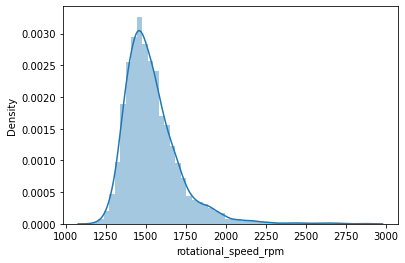

In [ ]:
sns.distplot(df['rotational_speed_rpm'])
#distribuição assimetrica a direita

**Rotational_speed_rpm**
* A concentração da velocidade foi de 1000 a 2250 rpm
* Media de 1500 rpm

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


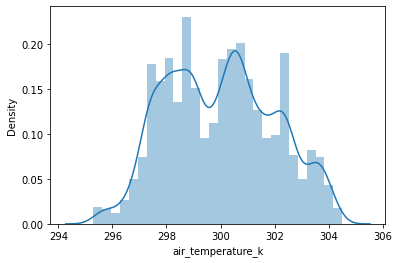

In [ ]:
sns.distplot(df['air_temperature_k'])
#distribuição normal 

**air_temperature_k**
* A concentração da velocidade foi de 295 a 304 rpm
* Media de 300 rpm

Como parte do processo de analise de dados, foi verificado os tipos de falhas, e a quantidade existente de cada falha.

In [ ]:
#tipos de falhas
df['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

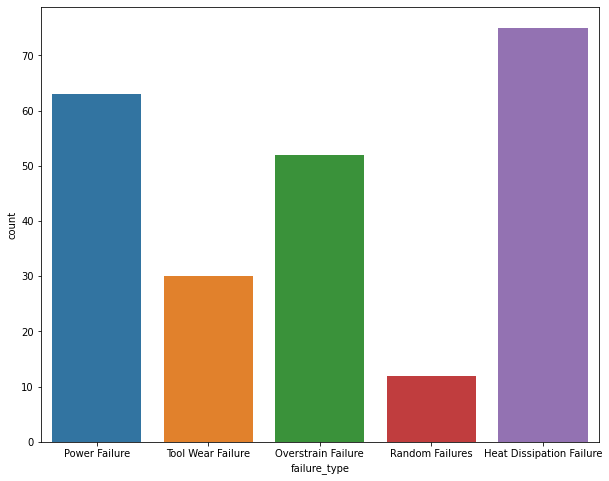

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data = df[df['target'] == 1], x = "failure_type")
#tipos de falhas


* No Failure                  6435
* Heat Dissipation Failure      75
* Power Failure                 63
* Overstrain Failure            52
* Tool Wear Failure             30
* Random Failures               12

Foi verificado quantas maquinas possuem falhas e quantas não possuem falhas

In [ ]:
df['target'].value_counts()
#0 = Sem Falhas
#1 = Com falhas

0    6435
1     232
Name: target, dtype: int64

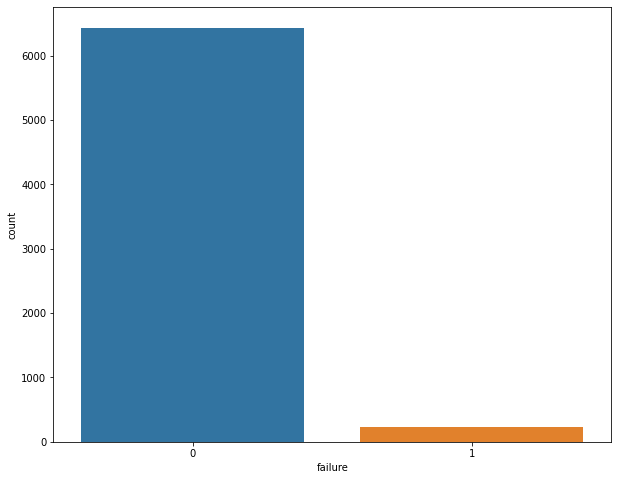

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(data = df, x = "failure")

* Maquinario com  falha: 6435
* Maquinario sem falhas: 232

Foi verificado a correlação das variaveis com a variavel heatmap

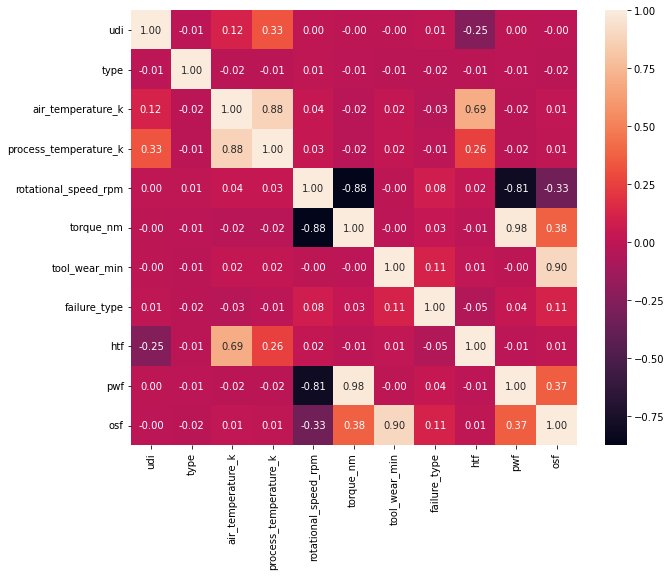

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot = True, fmt = ".2f")
#heat map


Correlação das variaveis com tipo de falha:
* tool_wear_min : 11%
* torque_nm: 3%
* rotational_speed: 8%
---
Correlação negativa:
* Air_temperature_k : -3%
* Process_temperature: -1%
* Type: -2%




Também foi feito o processo de engenharia de features que será detalhada logo a baixo.

### Feature enginering 

Para fazer o processo de feature engineering, foi utilizado o processo de enconder de algumas colunas categóricas, também foi feita a derivação de algumas colunas com as informações obtidas a partir da leitura da documentação fornecida. 

A coluna Failure type, sendo categorica, precisou ser transformada através do processo de Label enconder, onde eu transformei os tipos de falhas em valores inteiros numericos. 

In [66]:
# Encodando a coluna failure_type'.
le= preprocessing.LabelEncoder()
df['failure_type']= le.fit_transform(df['failure_type'])
df['failure_type'].unique()

array([1, 3, 5, 2, 4, 0])

A coluna type, também categorica possuindo três valores também foi transformada através da função map do pandas.
Onde:
L = 1
M = 2
H = 3

In [67]:
df['type'] = df['type'].map({'L': 1, 'M': 2,'H':3})

#replace L M & H  por numeros.

Este processo também foi feito na tabela df_teste, usada para previsão.

In [68]:
df_teste['type'] = df_teste['type'].map({'L': 1, 'M': 2,'H':3})

Após este processo de encoders de variaveis categoricas, foi feito o processo de derivação de variaveis. Estas informações  foram obtidas através da leitura da documentação fornecida, onde foi relatada como acontecia o processo de cada espécie de falha de maquinario. 

As variaveis derivadas nesta etapa foram 
* Heat Dissipation Failure  = HTF
* Power Failure = PWF
* Overstrain Failure = OSF 

As variaveis  Tool Wear Failure (Desgaste de maquina) e Random Failures(Falhas aleatórias) não foram derivações, pois ao meu entender não são variaveis passiveis de se quantificar a partir dos dados originais fornecidos.
Ambas as derivações, foram feias tanto para a dataframe de treino, quanto de teste.

A variavel heat dissipation failure (falha na dissipação de calor) foi obtida através da subtração da variavel air_temperature_k - process_temperature_k 

In [69]:
df['htf'] = df['air_temperature_k'] - df['process_temperature_k']
#'heat dissipation failure (HDF)'

In [70]:
df_teste['htf'] = df_teste['air_temperature_k'] - df_teste['process_temperature_k']


A varivavel power failure (falha de energia)  foi obtida através da multiplicação de rotational_speed_rpm  pela variavel torque_nm.
Também nesta estapa a variavel rotational_speed_rpm foi convertida para radianos por segundo(rad/s)

In [71]:
df['pwf'] = (df['rotational_speed_rpm']*0.10472) * (df['torque_nm'])  
#power failure (PWF)

In [72]:
df_teste['pwf'] = (df_teste['rotational_speed_rpm']*0.10472) * (df_teste['torque_nm'])  


A variavel overstrain failure (falha por sobrecarga),  foi obtida através da multiplicação de tool_wear_min por torque_nm

In [73]:
df['osf'] = df['tool_wear_min']*df['torque_nm']
#overstrain failure (OSF)

In [74]:
df_teste['osf'] = df_teste['tool_wear_min']*df_teste['torque_nm']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   6667 non-null   float64
 1   air_temperature_k      6667 non-null   float64
 2   process_temperature_k  6667 non-null   float64
 3   rotational_speed_rpm   6667 non-null   float64
 4   torque_nm              6667 non-null   float64
 5   tool_wear_min          6667 non-null   float64
 6   failure_type           6667 non-null   float64
 7   htf                    6667 non-null   float64
 8   pwf                    6667 non-null   float64
 9   osf                    6667 non-null   float64
dtypes: float64(10)
memory usage: 521.0 KB


In [75]:
df_teste['type'].value_counts()

1    1978
2    1010
3     345
Name: type, dtype: int64

In [ ]:
df.failure_type.value_counts()

1    6435
0      75
3      63
2      52
5      30
4      12
Name: failure_type, dtype: int64

Depois de terminado a parte de engenharia de features, aplicamos o standard scaler para normalizar os dados do dataframe. A escolha dessa técnica em especifica se deu após o teste de diferentes tipos de normalização, a que performou melhor e melhorou significativamente o F1 do modelo escolhido, foi a standard scaler.


In [76]:
#normalizando dados de treino
cols_to_norm = ['air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min','htf','pwf','osf']
colunas = df.columns
mms = MinMaxScaler()
df[cols_to_norm]= pd.DataFrame(mms.fit_transform(df[cols_to_norm]))


In [104]:
#normalizando dados de teste 
cols_to_norm = ['air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min','htf','pwf','osf']
colunas = df.columns
mms = MinMaxScaler()
df_teste[cols_to_norm]= pd.DataFrame(mms.fit_transform(df_teste[cols_to_norm]))

In [ ]:
df

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,failure,htf,pwf,osf
0,2,-0.948838,-0.935907,0.076652,0.275525,-1.706224,1,0,-0.501328,0.624349,-1.535128
1,1,-0.898702,-0.868702,-0.730484,0.627282,-1.658872,1,0,-0.501328,0.506930,-1.485855
2,1,-0.898702,-0.868702,-0.730484,-0.005881,-1.564168,1,0,-0.501328,-0.366567,-1.407423
3,2,-0.948838,-0.935907,-0.634531,0.185073,-1.532600,1,0,-0.501328,-0.032989,-1.371630
4,1,-0.948838,-0.935907,0.116163,0.235324,-1.485247,1,0,-0.501328,0.592483,-1.324556
...,...,...,...,...,...,...,...,...,...,...,...
6662,1,-0.597884,-1.137521,0.545130,-1.221954,-1.516816,1,0,0.501539,-1.423322,-1.416362
6663,2,-0.597884,-1.070317,0.375801,-1.061151,-1.485247,1,0,0.401252,-1.253023,-1.388622
6664,3,-0.547747,-1.070317,0.533841,-0.829996,-1.437895,1,0,0.501539,-0.802055,-1.343357
6665,3,-0.497611,-0.868702,-0.730484,0.848386,-1.311623,1,0,0.300966,0.811961,-1.105010


### Treinando o modelo

Após todo o processo de importação e tratamento dos dados, analise exploratória e engenharia de features, parti para a escolha do modelo a ser utilizado na previsão e treinamento do mesmo. Por ser um problema onde a variavel target a ser previsa era categórica, o modelo a ser previso é  um modelo de classificação.
Apesar dos varios modelos existentes para esse propósito, resolvi utilizar uma regressão logistia multinomial.Na regressão logistica multinomial o as variáveis de resposta podem incluir três ou mais variáveis, que não estarão em nenhuma ordem.O que é o caso da variavel target(failure_type).

Feita a importação dos pacotes,  fiz a divisão dos pacotes entre treino e validação. 


In [87]:
validation_set_ratio = 0.30
validation_set_size = int(len(df)*validation_set_ratio)
training_set_size = len(df) - validation_set_size
#dividindo o dataset entre validacao e treino

In [78]:
train, val = train_test_split(df, test_size=validation_set_ratio)


In [88]:
print("Dataframe total: {}".format(len(df)))
print("Tamanho treino: {}".format(training_set_size))
print("Tamanho Validação:: {}".format(validation_set_size))

Dataframe total: 6667
Tamanho treino: 4667
Tamanho Validação:: 2000


De 100% do dataframe 30% foi para validação 70% ara teste
Das 6667 linhas contidas no dataframe de treino, 4667 delas foram para treino e 2000 linhas para o dataset de validação

Criei a variavel columns, onde armazenou todas as variaveis existentes x 

In [89]:
columns = ['type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min','htf', 'pwf', 'osf']
#criando coluna para valores x

Armazenei as variaveis preditoras e a variavel target em train_x e train_y,val_x,val_y

In [90]:
# x para treino
train_X = df[columns]
train_y = df[['failure_type']] #y para teste
#x para val
val_X = val[columns]
#y para val 
val_y = val[['failure_type']]


Instanciei a regressão logistica.

In [91]:
lr = LogisticRegression(random_state=1, multi_class='multinomial', penalty='none', solver='newton-cg')


Treinei  a regressão logistica chamando a função fit.

In [92]:
lr.fit(train_X,train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='multinomial', penalty='none', random_state=1,
                   solver='newton-cg')

Após isso foi verificado o acerto do modelo através do metodo acurracy_score. O metodo acurracy_score é uma das medidas mais populares e mais eficazes para avaliar a precisão do algoritimos de classificação.

In [93]:
y_pred = lr.predict(train_X)
print("Accuracy:",metrics.accuracy_score(train_y, y_pred))
#acc treino

Accuracy: 0.983500824958752


Como observado no output gerado. O modelo obteve uma precisão de 97% na base de treino. O que é um otimo indicador de performance, para avaliar se não ocorreu um processo de overfitting no modelo treinado, também fiz a predição  na base de validação.

In [94]:
y_pred = lr.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))
#acc validação

Accuracy: 0.9854327335047129


A acuracia do modelo foi de 98% o que não diferenciou,  do nosso modelo de treino que chegou a cerca  de 97%. A  ausencia de uma porcentagem discrepante entre os valores de validação e de teste, indica que nosso modelo não sofreu um processo de overfiting.

Também gerei um classification report.

In [95]:
# matriz de confusao
print(confusion_matrix(val_y, y_pred))

# outras metricas
print(classification_report(val_y, y_pred))

[[  18    8    2    0    0    0]
 [   4 2244    1    2    0    0]
 [   0    0   18    0    0    0]
 [   0    1    1   19    0    0]
 [   0    5    0    0    0    0]
 [   0   10    0    0    0    1]]
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.99      1.00      0.99      2251
           2       0.82      1.00      0.90        18
           3       0.90      0.90      0.90        21
           4       0.00      0.00      0.00         5
           5       1.00      0.09      0.17        11

    accuracy                           0.99      2334
   macro avg       0.76      0.61      0.61      2334
weighted avg       0.98      0.99      0.98      2334



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos notar através do classification report, que nosso modelo acertou:

*   72% para erros do tipo 0
*   99% para erros do tipo 1 
*   90% para erros do tipo 2
*   90% para erros do tipo 3
*   0 % para erros do tipo 4
*   17% para erros do tipo 5

Com um F1 score geral de  99%





In [105]:

# prevendo os dados de validacao
pred = lr.predict(df_teste)

In [106]:
#criando dataframe submissão
df_sub = pd.read_csv('/content/desafio_manutencao_preditiva_teste.csv')

In [125]:
submission = pd.DataFrame({
        "rowNumber": df_sub["product_id"],
        "predictedValues": pred
    })

In [126]:
submission.head()

,rowNumber,predictedValues
0,L47625,1
1,L54255,1
2,L48370,1
3,L49797,1
4,L52246,1


In [128]:
#verficando quantidade de dados sub
submission.predictedValues.value_counts()

1    3163
3      87
0      45
2      36
5       2
Name: predictedValues, dtype: int64

In [129]:
submission.to_csv("pred.csv",sep=';',header=True,index=False)


In [130]:
import sys
print(sys.modules.keys())

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', 'types', 'enum', '_sre', 'sre_constants', 'sre_parse', 'sre_compile', '_collections_abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools', '_locale', 'copyreg', 're', 'warnings', '_stat', 'stat', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_bootlocale', 'importlib._bootstrap', 'importlib._bootstrap_external', 'importlib', 'importlib.machinery', 'importlib.abc', 'contextlib', 'importlib.util', 'google', 'google.cloud', 'google.logging', 'mpl_toolkits', 'sphinxcontrib', 'sitecustomize', 'site', '_weakrefset', 'weakref', 'pkgutil', 'runpy', 'ipykernel._version', '__future__', '

In [132]:
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=29e47892852be59b1345ed1f2faab6296aeaf57c9546b4ef141b826004abe220
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [1]:
!pip freeze


alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.11.0
anaconda-navigator==2.3.2
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functoo

In [144]:
!pipreqsnb

/bin/bash: pipreqsnb: command not found
